# Angular distance bias between sources and objects

- author Sylvie Dagoret-Campagne
- creation date 2024-04-05
- last update 2024-04-05
  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 


Apparently isolated sources are removed from object table


 

In [1]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom
import pickle
from astropy.stats import SigmaClip

In [2]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 'large'
plt.rcParams['axes.titlesize'] = 'large'
plt.rcParams['xtick.labelsize']= 'large'
plt.rcParams['ytick.labelsize']= 'large'

In [3]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [31]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

In [4]:
# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"
# collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20231207/w_2023_49/PREOPS-4648"
#collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871"
collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985"

collectionStr = collection.replace("/", "_")
instrument = "LATISS"
skymapName = "latiss_v1"

tract = 3864
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"



## Initiate butler from variables set above

In [5]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collection, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
skymap = butler.get("skyMap")
print("camera_name = {}".format(camera.getName()))
print("collection = {}".format(collection))

camera_name = LATISS
collection = LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985


## load isolated_star_sources

In [6]:
# Try to get the Schema
data_product = "isolated_star_sources"
datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collection, where= "instrument='LATISS'")
for i, ref in enumerate(datasetRefs):
    print(i,ref)
    butler_data = butler.get(ref)
    break

if not isinstance(butler_data, pd.core.frame.DataFrame):
    print(butler_data.getSchema())

0 isolated_star_sources@{instrument: 'LATISS', skymap: 'latiss_v1', tract: 5616} [sc=DataFrame] (run=LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240318T162806Z id=5f4f812e-80ee-4a4f-9c28-ee1d827a3288)


In [7]:
# Load in isolated_star_sources and trim to band of interest and select the tract
isolatedStarSourcesFull = butler.get("isolated_star_sources", tract=tract)
#isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["band"] == band]

In [8]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
0,720,178244558356742865,2023111500493,0,122.502818,-36.181373,empty~SDSSi_65mm,i,17929.311148,580.063968,3089.020434,3522.956779,18544.821571,817.794717,False,-0.084691,False,720,0


In [9]:
isolatedStarSourcesFull.head()

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
0,720,178244558356742865,2023111500493,0,122.502818,-36.181373,empty~SDSSi_65mm,i,17929.311148,580.063968,3089.020434,3522.956779,18544.821571,817.794717,False,-0.084691,False,720,0
1,657,178244564799193746,2023111500499,0,122.502820,-36.181372,empty~SDSSi_65mm,i,17965.443097,593.565729,1981.052932,3539.433919,18788.373258,839.011243,False,0.049484,False,657,0
2,690,178244568020419251,2023111500502,0,122.502819,-36.181372,empty~SDSSi_65mm,i,17309.856495,581.983397,1425.831515,3545.340924,17906.736267,821.413552,False,0.070277,False,690,0
3,481,178244580905320930,2023111500514,0,122.502817,-36.181374,empty~SDSSi_65mm,i,16563.487123,545.671588,3634.994108,2036.356179,16308.805325,776.241811,False,-0.196106,False,481,0
4,432,178244587347771825,2023111500520,0,122.502822,-36.181372,empty~SDSSi_65mm,i,17951.820662,577.548601,2527.386039,2051.742380,18624.356145,814.688326,False,0.041315,False,432,0


In [10]:
isolatedStarSourcesFull.tail()

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
163856,56,179546353280483385,2023122200468,0,122.636922,-36.166699,empty~SDSSy_65mm,y,6159.305843,570.340900,4029.261883,467.716012,NaN,NaN,True,-0.120178,False,56,1298
163857,6,178913118334746631,2023120400546,0,122.627449,-36.261951,empty~SDSSy_65mm,y,6002.652226,546.429347,3854.516501,69.447705,5149.290161,779.662392,False,-0.179842,False,6,1299
163858,289,181973644384141602,2024022900067,0,122.439252,-36.069256,empty~SDSSy_65mm,y,17046.173911,591.284537,1160.102547,3639.086131,19346.313383,837.526273,False,0.166535,False,289,1300
163859,311,181973652974076216,2024022900075,0,122.477861,-36.067847,empty~SDSSy_65mm,y,17262.146455,589.125479,1210.733303,3710.297643,17597.427159,831.424850,False,0.083739,False,311,1301
163860,149,179159378874597526,2023121100518,0,122.371089,-36.241101,empty~SDSSy_65mm,y,6536.212928,607.428677,112.776400,984.505377,7636.402888,864.654488,False,0.303516,False,149,1302


In [11]:
isolatedStarSourcesFull.columns

Index(['index', 'sourceId', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_35_0_instFlux',
       'apFlux_35_0_instFluxErr', 'x', 'y', 'apFlux_50_0_instFlux',
       'apFlux_50_0_instFluxErr', 'apFlux_50_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'source_row',
       'obj_index'],
      dtype='object')

In [12]:
#print(sorted(isolatedStarSourcesFull["visit"].unique()))

In [13]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
0,720,178244558356742865,2023111500493,0,122.502818,-36.181373,empty~SDSSi_65mm,i,17929.311148,580.063968,3089.020434,3522.956779,18544.821571,817.794717,False,-0.084691,False,720,0


In [63]:
isolatedStarSources_g = isolatedStarSourcesFull[isolatedStarSourcesFull.band=="g"]
isolatedStarSources_r = isolatedStarSourcesFull[isolatedStarSourcesFull.band=="r"]
isolatedStarSources_i = isolatedStarSourcesFull[isolatedStarSourcesFull.band=="i"]

## Load object table

In [18]:
#objectTable = butler.get("objectTable", tract=tract)

In [19]:
datasetRefs = butler.registry.queryDatasets(datasetType='objectTable', collections=collection, where= "instrument='LATISS'")

In [21]:
all_objectsTables = []

for i, ref in enumerate(datasetRefs):
    
    print("========================datasetType = objectTable ============================================")
    print("fullId..................:",ref.dataId.full)
    print("skymap...................:",ref.dataId["skymap"])
    print("tract....................:",ref.dataId["tract"])
    print("patch....................:",ref.dataId["patch"])
    print("run......................:",ref.run)

    if ref.dataId["tract"] == tract:
        df_tab=  butler.get(ref,collections=collection)
        all_objectsTables.append(df_tab) 

========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 3864, patch: 235}
skymap...................: latiss_v1
tract....................: 3864
patch....................: 235
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5615, patch: 331}
skymap...................: latiss_v1
tract....................: 5615
patch....................: 331
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5614, patch: 229}
skymap...................: latiss_v1
tract....................: 56

/tmp/ipykernel_23322/1589542278.py:6: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)
/tmp/ipykernel_23322/1589542278.py:13: UserWarning: Collections should not be specified with DatasetRef
  df_tab=  butler.get(ref,collections=collection)
/tmp/ipykernel_23322/1589542278.py:6: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)
/tmp/ipykernel_23322/1589542278.py:13: UserWarning: Collections should not be specified with DatasetRef
  df_tab=  butler.get(ref,collections=collection)


========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5634, patch: 112}
skymap...................: latiss_v1
tract....................: 5634
patch....................: 112
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5614, patch: 211}
skymap...................: latiss_v1
tract....................: 5614
patch....................: 211
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5615, patch: 276}
skymap...................: latiss_v1
tract....................: 56

/tmp/ipykernel_23322/1589542278.py:6: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)
/tmp/ipykernel_23322/1589542278.py:13: UserWarning: Collections should not be specified with DatasetRef
  df_tab=  butler.get(ref,collections=collection)
/tmp/ipykernel_23322/1589542278.py:6: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)
/tmp/ipykernel_23322/1589542278.py:13: UserWarning: Collections should not be specified with DatasetRef
  df_tab=  butler.get(ref,collections=collection)


========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5634, patch: 71}
skymap...................: latiss_v1
tract....................: 5634
patch....................: 71
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5615, patch: 295}
skymap...................: latiss_v1
tract....................: 5615
patch....................: 295
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5634, patch: 54}
skymap...................: latiss_v1
tract....................: 5634


/tmp/ipykernel_23322/1589542278.py:6: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)
/tmp/ipykernel_23322/1589542278.py:13: UserWarning: Collections should not be specified with DatasetRef
  df_tab=  butler.get(ref,collections=collection)
/tmp/ipykernel_23322/1589542278.py:6: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)
/tmp/ipykernel_23322/1589542278.py:13: UserWarning: Collections should not be specified with DatasetRef
  df_tab=  butler.get(ref,collections=collection)


========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5614, patch: 230}
skymap...................: latiss_v1
tract....................: 5614
patch....................: 230
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 3864, patch: 217}
skymap...................: latiss_v1
tract....................: 3864
patch....................: 217
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z


/tmp/ipykernel_23322/1589542278.py:6: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)
/tmp/ipykernel_23322/1589542278.py:13: UserWarning: Collections should not be specified with DatasetRef
  df_tab=  butler.get(ref,collections=collection)


========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5614, patch: 250}
skymap...................: latiss_v1
tract....................: 5614
patch....................: 250
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5614, patch: 231}
skymap...................: latiss_v1
tract....................: 5614
patch....................: 231
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 3864, patch: 257}
skymap...................: latiss_v1
tract....................: 38

/tmp/ipykernel_23322/1589542278.py:6: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)
/tmp/ipykernel_23322/1589542278.py:13: UserWarning: Collections should not be specified with DatasetRef
  df_tab=  butler.get(ref,collections=collection)
/tmp/ipykernel_23322/1589542278.py:6: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)
/tmp/ipykernel_23322/1589542278.py:13: UserWarning: Collections should not be specified with DatasetRef
  df_tab=  butler.get(ref,collections=collection)


========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5615, patch: 313}
skymap...................: latiss_v1
tract....................: 5615
patch....................: 313
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5634, patch: 109}
skymap...................: latiss_v1
tract....................: 5634
patch....................: 109
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5634, patch: 90}
skymap...................: latiss_v1
tract....................: 563

/tmp/ipykernel_23322/1589542278.py:6: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)
/tmp/ipykernel_23322/1589542278.py:13: UserWarning: Collections should not be specified with DatasetRef
  df_tab=  butler.get(ref,collections=collection)


========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 3864, patch: 216}
skymap...................: latiss_v1
tract....................: 3864
patch....................: 216
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 3864, patch: 274}
skymap...................: latiss_v1
tract....................: 3864
patch....................: 274
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z


/tmp/ipykernel_23322/1589542278.py:6: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)
/tmp/ipykernel_23322/1589542278.py:13: UserWarning: Collections should not be specified with DatasetRef
  df_tab=  butler.get(ref,collections=collection)
/tmp/ipykernel_23322/1589542278.py:6: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)
/tmp/ipykernel_23322/1589542278.py:13: UserWarning: Collections should not be specified with DatasetRef
  df_tab=  butler.get(ref,collections=collection)


========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5614, patch: 210}
skymap...................: latiss_v1
tract....................: 5614
patch....................: 210
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5615, patch: 274}
skymap...................: latiss_v1
tract....................: 5615
patch....................: 274
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 3864, patch: 256}
skymap...................: latiss_v1
tract....................: 38

/tmp/ipykernel_23322/1589542278.py:6: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)
/tmp/ipykernel_23322/1589542278.py:13: UserWarning: Collections should not be specified with DatasetRef
  df_tab=  butler.get(ref,collections=collection)


========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5614, patch: 232}
skymap...................: latiss_v1
tract....................: 5614
patch....................: 232
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5615, patch: 332}
skymap...................: latiss_v1
tract....................: 5615
patch....................: 332
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5614, patch: 249}
skymap...................: latiss_v1
tract....................: 56

/tmp/ipykernel_23322/1589542278.py:6: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)
/tmp/ipykernel_23322/1589542278.py:13: UserWarning: Collections should not be specified with DatasetRef
  df_tab=  butler.get(ref,collections=collection)


========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5634, patch: 93}
skymap...................: latiss_v1
tract....................: 5634
patch....................: 93
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5614, patch: 213}
skymap...................: latiss_v1
tract....................: 5614
patch....................: 213
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240325T235604Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5615, patch: 293}
skymap...................: latiss_v1
tract....................: 5615

/tmp/ipykernel_23322/1589542278.py:6: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)
/tmp/ipykernel_23322/1589542278.py:13: UserWarning: Collections should not be specified with DatasetRef
  df_tab=  butler.get(ref,collections=collection)


========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 5634, patch: 53}
skymap...................: latiss_v1
tract....................: 5634
patch....................: 53
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240326T194558Z
========================datasetType = objectTable ============================================
fullId..................: {skymap: 'latiss_v1', tract: 3864, patch: 237}
skymap...................: latiss_v1
tract....................: 3864
patch....................: 237
run......................: LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985/20240327T020726Z


/tmp/ipykernel_23322/1589542278.py:6: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)
/tmp/ipykernel_23322/1589542278.py:13: UserWarning: Collections should not be specified with DatasetRef
  df_tab=  butler.get(ref,collections=collection)


In [23]:
objectTable = pd.concat(all_objectsTables)

In [78]:
#list(objectTable.columns)

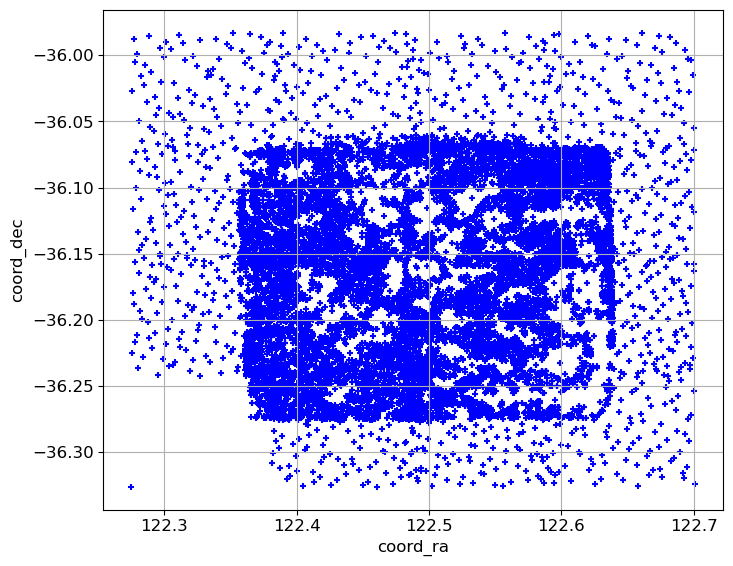

In [77]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
objectTable.plot.scatter(x="coord_ra",y="coord_dec",marker="+",color='b',grid=True,ax=ax)
plt.gca().set_aspect('equal')
#plt.grid()

In [42]:
#objectTable[objectTable.detect_isPrimary].refSizeExtendedness.hist(bins=50)

In [44]:
selection = (objectTable.refSizeExtendedness<0.1) & (objectTable.detect_isPrimary) & (objectTable.detect_isIsolated)

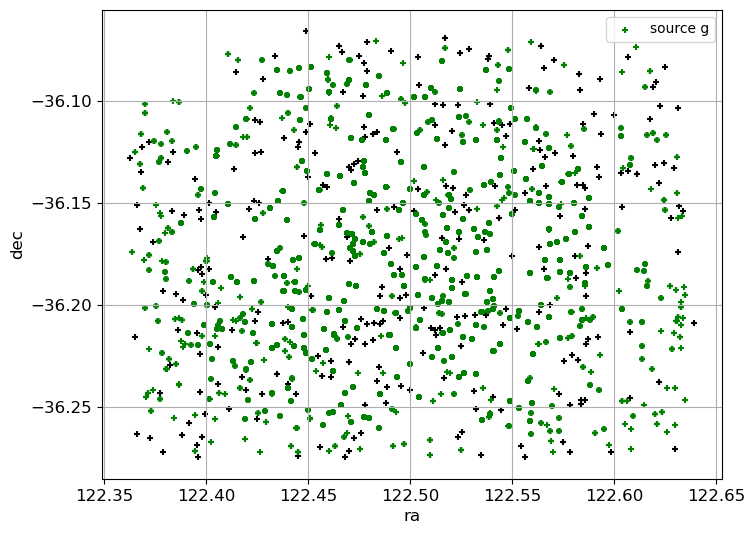

In [70]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
objectTable[selection].plot.scatter(x="coord_ra",y="coord_dec",marker="+",color='k',ax=ax)
isolatedStarSources_g.plot.scatter(x="ra",y="dec",marker="+",color="g",ax=ax,label="sources g")
plt.gca().set_aspect('equal')
plt.grid()

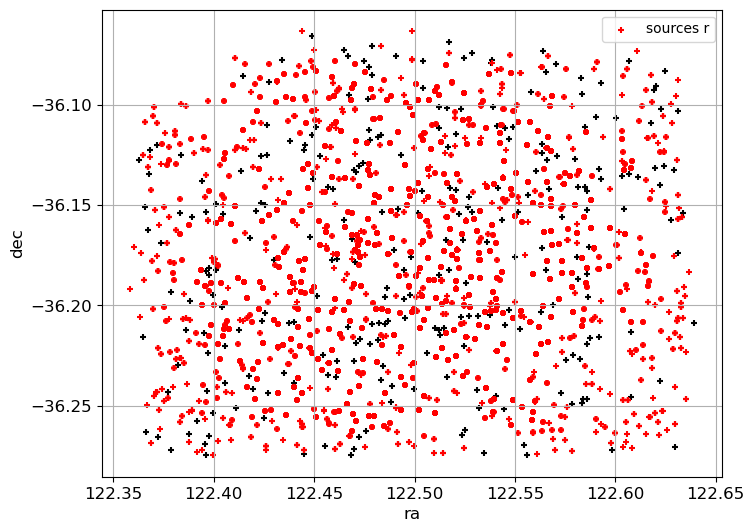

In [71]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
objectTable[selection].plot.scatter(x="coord_ra",y="coord_dec",marker="+",color='k',ax=ax)
isolatedStarSources_r.plot.scatter(x="ra",y="dec",marker="+",color="r",ax=ax,label="sources r")
plt.gca().set_aspect('equal')
plt.grid()

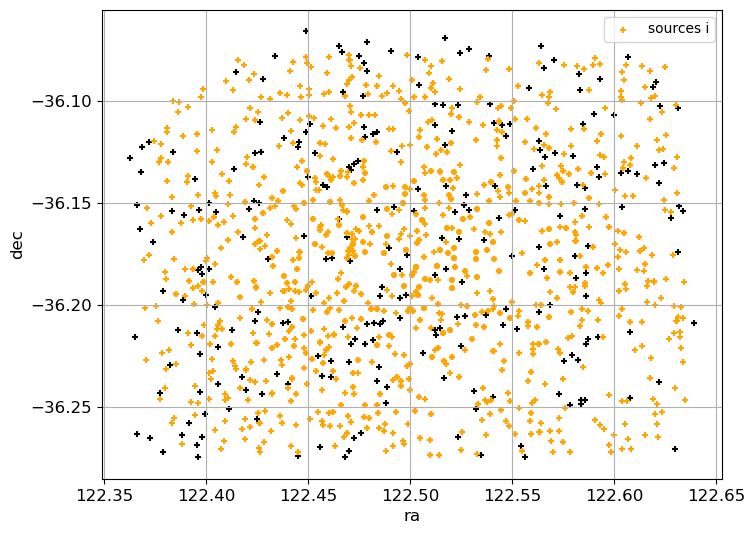

In [72]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
objectTable[selection].plot.scatter(x="coord_ra",y="coord_dec",marker="+",color='k',ax=ax)
isolatedStarSources_i.plot.scatter(x="ra",y="dec",marker="+",color="orange",ax=ax,label="sources i")
plt.gca().set_aspect('equal')
plt.grid()

In [38]:
#objectTable[objectTable.refSizeExtendedness>0.9].plot.scatter(x="coord_ra",y="coord_dec",marker="+")

In [46]:
isolatedObjects = objectTable[selection]

In [58]:
isolatedObjects["g_psfMag"] = isolatedObjects["g_psfFlux"].map(convert_fluxtomag)
isolatedObjects["r_psfMag"] = isolatedObjects["r_psfFlux"].map(convert_fluxtomag)
isolatedObjects["i_psfMag"] = isolatedObjects["i_psfFlux"].map(convert_fluxtomag)
#isolatedObjects["z_psfMag"] = isolatedObjects["z_psfFlux"].apply(convert_fluxtomag)
#isolatedObjects["y_psfMag"] = isolatedObjects["y_psfFlux"].apply(convert_fluxtomag)

/tmp/ipykernel_23322/4088867659.py:12: RuntimeWarning: invalid value encountered in log10
  return -2.50 * np.log10(x) + 31.4
/tmp/ipykernel_23322/1524233045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isolatedObjects["g_psfMag"] = isolatedObjects["g_psfFlux"].map(convert_fluxtomag)
/tmp/ipykernel_23322/1524233045.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isolatedObjects["r_psfMag"] = isolatedObjects["r_psfFlux"].map(convert_fluxtomag)
/tmp/ipykernel_23322/1524233045.py:3: SettingWithCopyW

<Axes: >

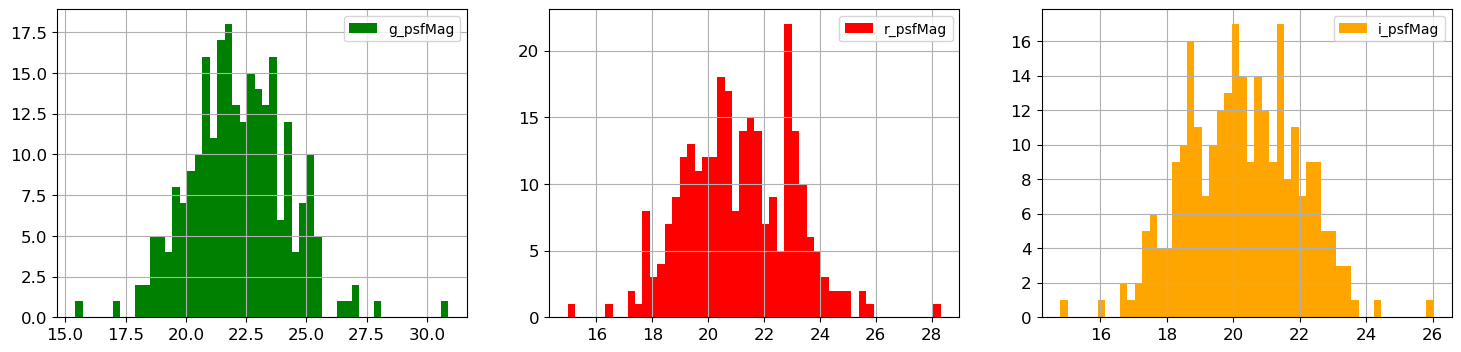

In [61]:
fig,axs = plt.subplots(1,3,figsize=(18,4))
ax1,ax2,ax3 = axs.flatten()
isolatedObjects["g_psfMag"].hist(bins=50,facecolor="g",ax=ax1,legend="g")
isolatedObjects["r_psfMag"].hist(bins=50,facecolor="r",ax=ax2,legend="r")
isolatedObjects["i_psfMag"].hist(bins=50,facecolor="orange",ax=ax3,legend="i")